In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping

2024-02-01 21:40:58.118317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 21:40:58.118356: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 21:40:58.119764: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-01 21:40:58.242011: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size = (100, 100)
batch_size = 32

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "dataset/class_eye_train",
    validation_split=0.2,
    subset="both",
    seed=911,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7070 files belonging to 2 classes.
Using 5656 files for training.
Using 1414 files for validation.


2024-02-01 21:41:00.975447: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 21:41:00.980382: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-01 21:41:00.980670: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

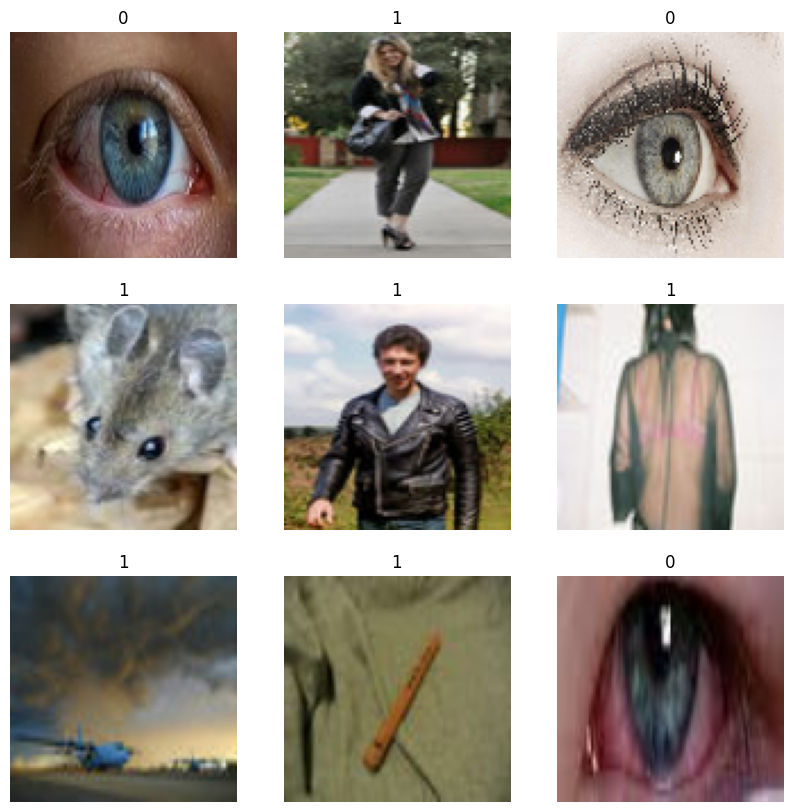

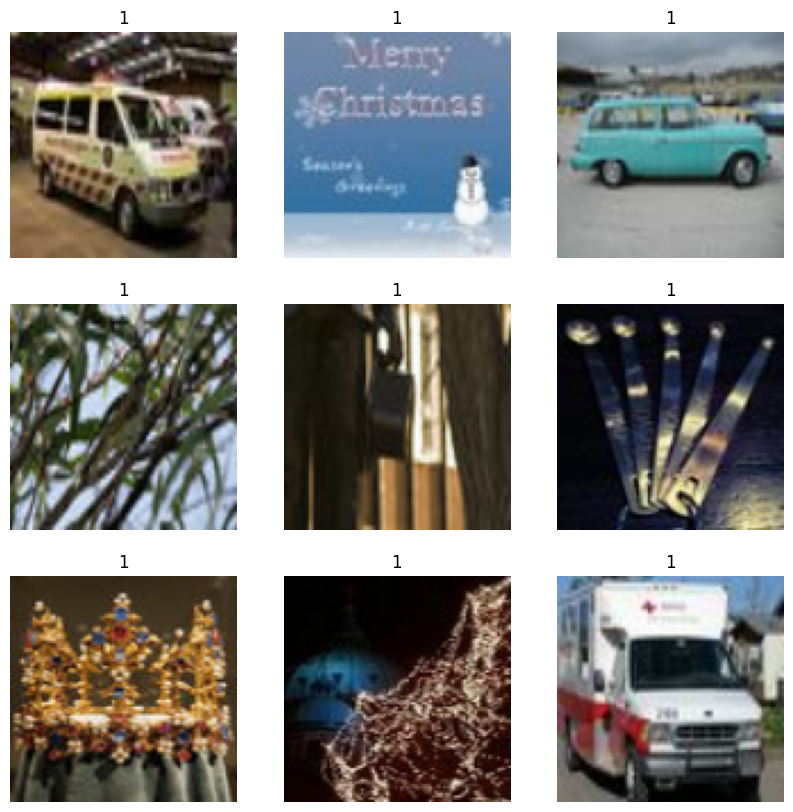

In [3]:
for images, labels in train_ds.take(2):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
# data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomContrast(factor=0.3),
        layers.RandomBrightness(factor=0.3)
    ]
)   

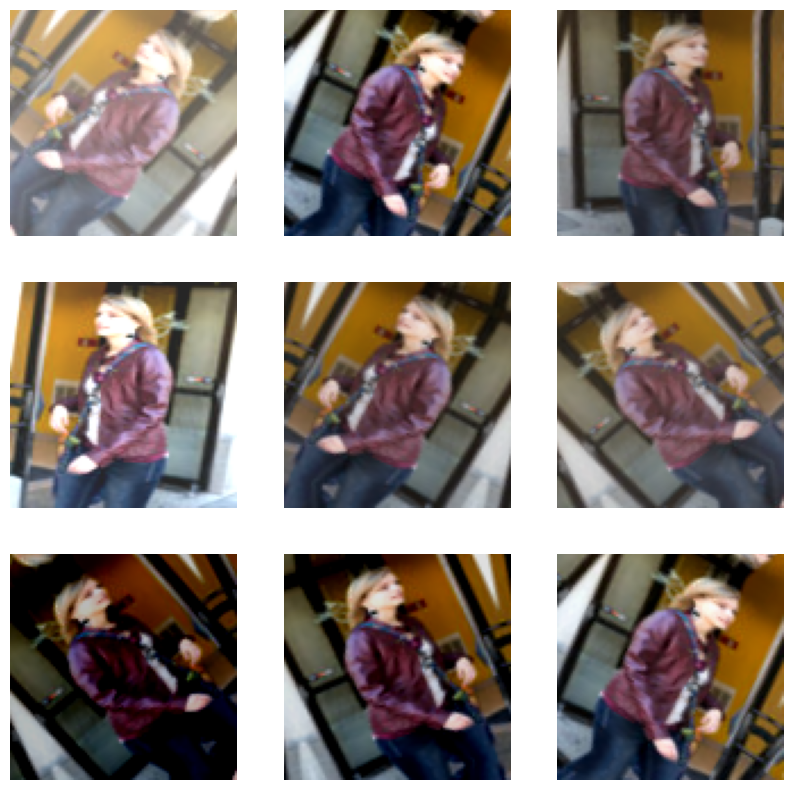

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [7]:
def class_eye(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 2
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [8]:
model = class_eye(input_shape=image_size + (3,), num_classes=2)

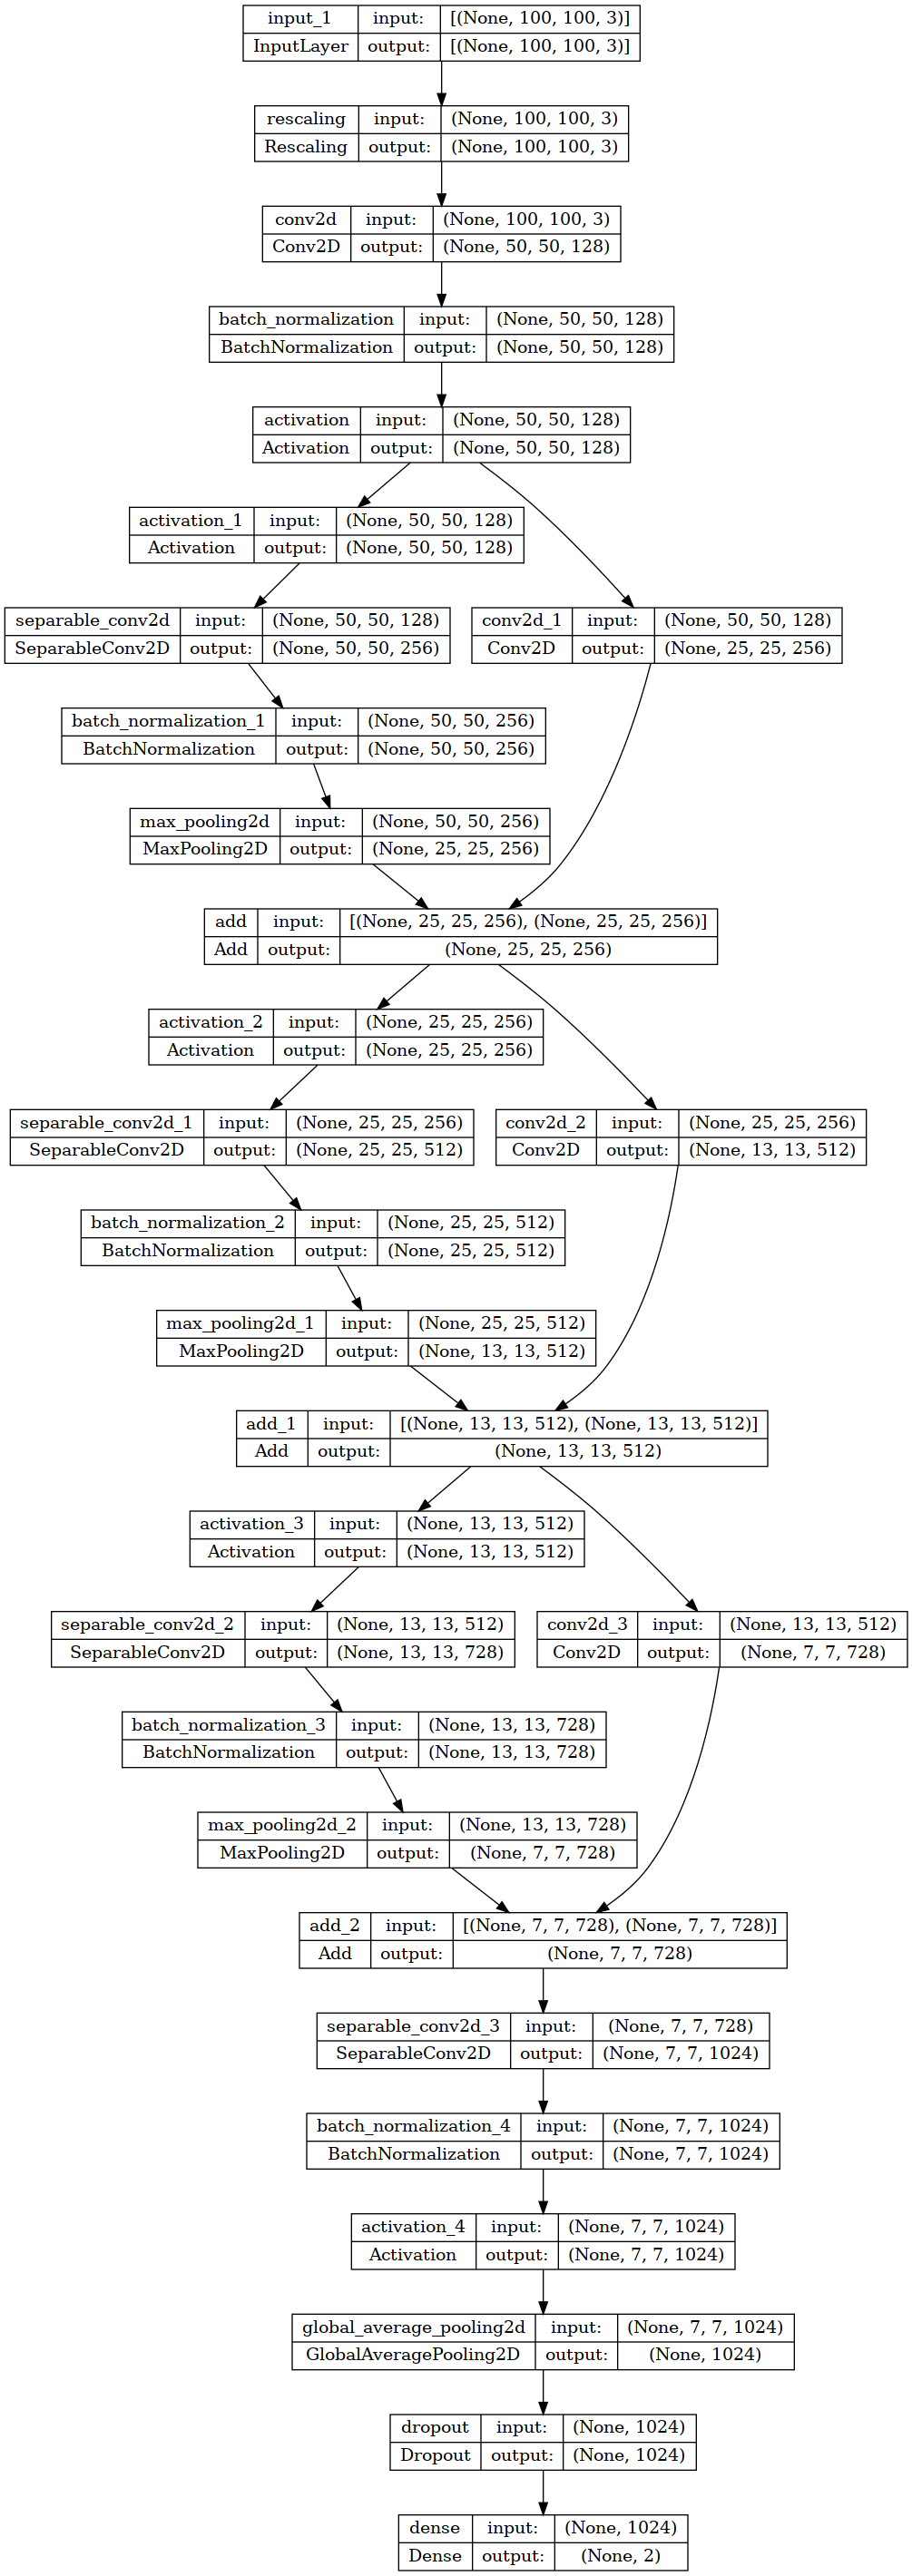

In [9]:
keras.utils.plot_model(model, show_shapes=True)

In [10]:
early_stopping_monitor = EarlyStopping(
    monitor="val_accuracy",
    min_delta=0,
    patience=5,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=5
    )

In [11]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(train_ds,
    epochs=10,
    callbacks=[early_stopping_monitor],
    validation_data=val_ds
    )

Epoch 1/10


2024-02-01 21:41:07.684495: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-02-01 21:41:12.328493: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xa929a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-01 21:41:12.328527: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2024-02-01 21:41:12.334843: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-01 21:41:12.418951: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  3/177 [..............................] - ETA: 54s - loss: 0.8309 - accuracy: 0.5729 

2024-02-01 21:41:22.509640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.3873 - accuracy: 0.8496

2024-02-01 21:41:26.569849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.3215 - accuracy: 0.8802

2024-02-01 21:41:29.079779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.3239 - accuracy: 0.8854

2024-02-01 21:41:30.001259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 44s - loss: 0.2902 - accuracy: 0.8939

2024-02-01 21:41:31.872307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.2533 - accuracy: 0.9055

2024-02-01 21:41:35.311204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.2282 - accuracy: 0.9152

2024-02-01 21:41:39.056212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.2317 - accuracy: 0.9167

2024-02-01 21:41:40.319447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.2384 - accuracy: 0.9160

2024-02-01 21:41:42.485436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.2397 - accuracy: 0.9140

2024-02-01 21:41:45.610266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.2300 - accuracy: 0.9167

2024-02-01 21:41:47.800794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9194

2024-02-01 21:41:49.043850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.2201 - accuracy: 0.9214

2024-02-01 21:41:51.222904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.2087 - accuracy: 0.9260

2024-02-01 21:41:54.657327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.2043 - accuracy: 0.9282

2024-02-01 21:41:58.097078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.2013 - accuracy: 0.9291

2024-02-01 21:42:01.216016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.1974 - accuracy: 0.9314

2024-02-01 21:42:03.087842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.1963 - accuracy: 0.9319

2024-02-01 21:42:03.400487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.1962 - accuracy: 0.9319

2024-02-01 21:42:03.723464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.1954 - accuracy: 0.9323

2024-02-01 21:42:04.334811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:42:04.338245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.1920 - accuracy: 0.9336

2024-02-01 21:42:06.221975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.1901 - accuracy: 0.9345

2024-02-01 21:42:07.145108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.1781 - accuracy: 0.9390

2024-02-01 21:42:25.953321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:42:27.627933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:42:28.663045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:42:29.073837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:42:29.833817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:42:31.247626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:42:31.255277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 87s 402ms/step - loss: 0.1781 - accuracy: 0.9390 - val_loss: 0.4847 - val_accuracy: 0.9081
Epoch 2/10
  3/177 [..............................] - ETA: 55s - loss: 0.2103 - accuracy: 0.9375

2024-02-01 21:42:33.741512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.1387 - accuracy: 0.9473

2024-02-01 21:42:37.799636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.1210 - accuracy: 0.9531

2024-02-01 21:42:40.303307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.1201 - accuracy: 0.9514

2024-02-01 21:42:41.230297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 44s - loss: 0.1077 - accuracy: 0.9574

2024-02-01 21:42:43.103987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.1097 - accuracy: 0.9588

2024-02-01 21:42:46.539565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.1074 - accuracy: 0.9598

2024-02-01 21:42:50.289666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.1077 - accuracy: 0.9594

2024-02-01 21:42:51.537310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.1083 - accuracy: 0.9590

2024-02-01 21:42:53.715505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.1129 - accuracy: 0.9570

2024-02-01 21:42:56.836944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.1172 - accuracy: 0.9557

2024-02-01 21:42:59.025894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.1165 - accuracy: 0.9556

2024-02-01 21:43:00.271135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.1203 - accuracy: 0.9549

2024-02-01 21:43:02.452140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.1211 - accuracy: 0.9564

2024-02-01 21:43:05.888177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.1188 - accuracy: 0.9573

2024-02-01 21:43:09.322453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.1191 - accuracy: 0.9562

2024-02-01 21:43:12.441892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.1183 - accuracy: 0.9568

2024-02-01 21:43:14.316289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.1184 - accuracy: 0.9564

2024-02-01 21:43:14.628439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.1182 - accuracy: 0.9563

2024-02-01 21:43:14.949760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.1175 - accuracy: 0.9567

2024-02-01 21:43:15.565700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:43:15.566684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.1167 - accuracy: 0.9565

2024-02-01 21:43:17.444902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.1157 - accuracy: 0.9570

2024-02-01 21:43:18.375144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.1142 - accuracy: 0.9570

2024-02-01 21:43:28.022830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:43:28.410798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:43:29.443570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:43:29.855815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:43:30.609127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:43:32.018790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:43:32.128037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.1142 - accuracy: 0.9570 - val_loss: 0.3087 - val_accuracy: 0.9081
Epoch 3/10
  3/177 [..............................] - ETA: 55s - loss: 0.1487 - accuracy: 0.9583

2024-02-01 21:43:33.715706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.1100 - accuracy: 0.9668

2024-02-01 21:43:37.784186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.1091 - accuracy: 0.9661

2024-02-01 21:43:40.301150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.1021 - accuracy: 0.9688

2024-02-01 21:43:41.215757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 45s - loss: 0.0967 - accuracy: 0.9706

2024-02-01 21:43:43.091383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.0821 - accuracy: 0.9744

2024-02-01 21:43:46.534299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.0847 - accuracy: 0.9732

2024-02-01 21:43:50.285460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.0890 - accuracy: 0.9698

2024-02-01 21:43:51.543166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.0868 - accuracy: 0.9697

2024-02-01 21:43:53.716080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.0876 - accuracy: 0.9700

2024-02-01 21:43:56.848639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.0851 - accuracy: 0.9706

2024-02-01 21:43:59.044998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.0853 - accuracy: 0.9705

2024-02-01 21:44:00.282172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.0828 - accuracy: 0.9717

2024-02-01 21:44:02.466173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.0799 - accuracy: 0.9726

2024-02-01 21:44:05.901871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.0796 - accuracy: 0.9733

2024-02-01 21:44:09.334156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.0852 - accuracy: 0.9722

2024-02-01 21:44:12.459457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.0865 - accuracy: 0.9718

2024-02-01 21:44:14.334093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.0863 - accuracy: 0.9718

2024-02-01 21:44:14.643628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.0881 - accuracy: 0.9711

2024-02-01 21:44:14.970474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.0872 - accuracy: 0.9715

2024-02-01 21:44:15.578281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:44:15.581720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.0861 - accuracy: 0.9716

2024-02-01 21:44:17.470635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.0858 - accuracy: 0.9717

2024-02-01 21:44:18.394046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.0833 - accuracy: 0.9722

2024-02-01 21:44:28.047244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:44:28.437174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:44:29.471768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:44:29.884023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:44:30.639461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:44:32.049602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:44:32.158266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.0833 - accuracy: 0.9722 - val_loss: 0.1364 - val_accuracy: 0.9653
Epoch 4/10
  3/177 [..............................] - ETA: 55s - loss: 0.1032 - accuracy: 0.9479

2024-02-01 21:44:33.767678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.0941 - accuracy: 0.9590

2024-02-01 21:44:37.829714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.0761 - accuracy: 0.9661

2024-02-01 21:44:40.346460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.0716 - accuracy: 0.9688

2024-02-01 21:44:41.264580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 45s - loss: 0.0684 - accuracy: 0.9716

2024-02-01 21:44:43.139139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.0688 - accuracy: 0.9730

2024-02-01 21:44:46.579385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.0736 - accuracy: 0.9704

2024-02-01 21:44:50.336345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.0764 - accuracy: 0.9698

2024-02-01 21:44:51.602190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.0739 - accuracy: 0.9706

2024-02-01 21:44:53.762159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.0775 - accuracy: 0.9696

2024-02-01 21:44:56.891961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.0757 - accuracy: 0.9706

2024-02-01 21:44:59.084555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.0762 - accuracy: 0.9705

2024-02-01 21:45:00.327682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.0724 - accuracy: 0.9724

2024-02-01 21:45:02.508515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.0690 - accuracy: 0.9732

2024-02-01 21:45:05.943106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.0684 - accuracy: 0.9741

2024-02-01 21:45:09.380735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.0677 - accuracy: 0.9744

2024-02-01 21:45:12.499064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.0708 - accuracy: 0.9732

2024-02-01 21:45:14.371955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.0707 - accuracy: 0.9734

2024-02-01 21:45:14.680969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.0717 - accuracy: 0.9729

2024-02-01 21:45:15.004034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.0712 - accuracy: 0.9731

2024-02-01 21:45:15.615626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:45:15.619359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.0709 - accuracy: 0.9736

2024-02-01 21:45:17.509503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.0704 - accuracy: 0.9737

2024-02-01 21:45:18.432846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9751

2024-02-01 21:45:28.081384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:45:28.468053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:45:29.500713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:45:29.912101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:45:30.672088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:45:32.100307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:45:32.107785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.0668 - accuracy: 0.9751 - val_loss: 0.1461 - val_accuracy: 0.9413
Epoch 5/10
  3/177 [..............................] - ETA: 55s - loss: 0.0441 - accuracy: 0.9896

2024-02-01 21:45:33.796846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.0466 - accuracy: 0.9844

2024-02-01 21:45:37.858136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.0587 - accuracy: 0.9831

2024-02-01 21:45:40.372897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.0555 - accuracy: 0.9826

2024-02-01 21:45:41.289070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 45s - loss: 0.0509 - accuracy: 0.9839

2024-02-01 21:45:43.165803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.0552 - accuracy: 0.9837

2024-02-01 21:45:46.597283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.0575 - accuracy: 0.9821

2024-02-01 21:45:50.347109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.0559 - accuracy: 0.9833

2024-02-01 21:45:51.596486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.0594 - accuracy: 0.9823

2024-02-01 21:45:53.779494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.0551 - accuracy: 0.9838

2024-02-01 21:45:56.901639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.0544 - accuracy: 0.9836

2024-02-01 21:45:59.092797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.0554 - accuracy: 0.9833

2024-02-01 21:46:00.341516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.0541 - accuracy: 0.9836

2024-02-01 21:46:02.520219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.0531 - accuracy: 0.9838

2024-02-01 21:46:05.958042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.0536 - accuracy: 0.9842

2024-02-01 21:46:09.393467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.0550 - accuracy: 0.9830

2024-02-01 21:46:12.516719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.0547 - accuracy: 0.9831

2024-02-01 21:46:14.389936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.0544 - accuracy: 0.9832

2024-02-01 21:46:14.703292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.0541 - accuracy: 0.9833

2024-02-01 21:46:15.018230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.0548 - accuracy: 0.9829

2024-02-01 21:46:15.640873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:46:15.641977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.0543 - accuracy: 0.9830

2024-02-01 21:46:17.520622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.0541 - accuracy: 0.9829

2024-02-01 21:46:18.453236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.0522 - accuracy: 0.9830

2024-02-01 21:46:28.116176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:46:28.504634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:46:29.538844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:46:29.953991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:46:30.707885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:46:32.111222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:46:32.224673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.0522 - accuracy: 0.9830 - val_loss: 0.2248 - val_accuracy: 0.9477
Epoch 6/10
  3/177 [..............................] - ETA: 55s - loss: 0.0928 - accuracy: 0.9688

2024-02-01 21:46:33.817462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.0487 - accuracy: 0.9883

2024-02-01 21:46:37.877232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.0611 - accuracy: 0.9831

2024-02-01 21:46:40.383947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.0646 - accuracy: 0.9815

2024-02-01 21:46:41.314864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 45s - loss: 0.0621 - accuracy: 0.9820

2024-02-01 21:46:43.191206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.0683 - accuracy: 0.9808

2024-02-01 21:46:46.629559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.0645 - accuracy: 0.9810

2024-02-01 21:46:50.377694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.0630 - accuracy: 0.9812

2024-02-01 21:46:51.632530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.0649 - accuracy: 0.9804

2024-02-01 21:46:53.815153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.0660 - accuracy: 0.9801

2024-02-01 21:46:56.940057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.0647 - accuracy: 0.9803

2024-02-01 21:46:59.127130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.0628 - accuracy: 0.9808

2024-02-01 21:47:00.378301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.0611 - accuracy: 0.9812

2024-02-01 21:47:02.557767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.0572 - accuracy: 0.9820

2024-02-01 21:47:05.992415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.0549 - accuracy: 0.9829

2024-02-01 21:47:09.428768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.0558 - accuracy: 0.9828

2024-02-01 21:47:12.548473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.0565 - accuracy: 0.9826

2024-02-01 21:47:14.421741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.0567 - accuracy: 0.9823

2024-02-01 21:47:14.734640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.0564 - accuracy: 0.9824

2024-02-01 21:47:15.048925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.0561 - accuracy: 0.9827

2024-02-01 21:47:15.671994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:47:15.673062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.0556 - accuracy: 0.9830

2024-02-01 21:47:17.554217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.0553 - accuracy: 0.9829

2024-02-01 21:47:18.485992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.9834

2024-02-01 21:47:28.135970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:47:28.524666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:47:29.557494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:47:29.968810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:47:30.728754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:47:32.141720: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:47:32.249980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.0524 - accuracy: 0.9834 - val_loss: 0.1090 - val_accuracy: 0.9533
Epoch 7/10
  3/177 [..............................] - ETA: 55s - loss: 0.0269 - accuracy: 0.9896

2024-02-01 21:47:33.878988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.0456 - accuracy: 0.9824

2024-02-01 21:47:37.938071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.0373 - accuracy: 0.9857

2024-02-01 21:47:40.439214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.0406 - accuracy: 0.9850

2024-02-01 21:47:41.370959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 45s - loss: 0.0413 - accuracy: 0.9848

2024-02-01 21:47:43.244724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.0456 - accuracy: 0.9830

2024-02-01 21:47:46.680889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.0499 - accuracy: 0.9816

2024-02-01 21:47:50.428074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.0481 - accuracy: 0.9823

2024-02-01 21:47:51.678576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.0466 - accuracy: 0.9823

2024-02-01 21:47:53.859622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.0463 - accuracy: 0.9834

2024-02-01 21:47:56.984646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.0491 - accuracy: 0.9833

2024-02-01 21:47:59.175374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.0490 - accuracy: 0.9833

2024-02-01 21:48:00.422833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.0506 - accuracy: 0.9836

2024-02-01 21:48:02.604441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.0543 - accuracy: 0.9829

2024-02-01 21:48:06.041362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.0525 - accuracy: 0.9837

2024-02-01 21:48:09.481163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.0528 - accuracy: 0.9833

2024-02-01 21:48:12.603483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.0549 - accuracy: 0.9821

2024-02-01 21:48:14.477491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.0546 - accuracy: 0.9823

2024-02-01 21:48:14.790477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.0543 - accuracy: 0.9824

2024-02-01 21:48:15.104904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.0536 - accuracy: 0.9827

2024-02-01 21:48:15.727978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:48:15.728883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.0544 - accuracy: 0.9823

2024-02-01 21:48:17.609354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.0542 - accuracy: 0.9824

2024-02-01 21:48:18.543312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9825

2024-02-01 21:48:28.197342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:48:28.586833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:48:29.619711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:48:30.029892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:48:30.791413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:48:32.209870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:48:32.214746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.0535 - accuracy: 0.9825 - val_loss: 0.0371 - val_accuracy: 0.9908
Epoch 8/10
  3/177 [..............................] - ETA: 55s - loss: 0.0078 - accuracy: 1.0000

2024-02-01 21:48:33.939473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.0449 - accuracy: 0.9883

2024-02-01 21:48:38.002135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.0395 - accuracy: 0.9896

2024-02-01 21:48:40.506088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.0386 - accuracy: 0.9896

2024-02-01 21:48:41.436578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 45s - loss: 0.0352 - accuracy: 0.9896

2024-02-01 21:48:43.310691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.0405 - accuracy: 0.9872

2024-02-01 21:48:46.744838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.0393 - accuracy: 0.9872

2024-02-01 21:48:50.493503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.0427 - accuracy: 0.9859

2024-02-01 21:48:51.745029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.0403 - accuracy: 0.9865

2024-02-01 21:48:53.927772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.0397 - accuracy: 0.9870

2024-02-01 21:48:57.051559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.0381 - accuracy: 0.9874

2024-02-01 21:48:59.242048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.0397 - accuracy: 0.9865

2024-02-01 21:49:00.489478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.0392 - accuracy: 0.9865

2024-02-01 21:49:02.668114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.0390 - accuracy: 0.9864

2024-02-01 21:49:06.105011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.0370 - accuracy: 0.9872

2024-02-01 21:49:09.542145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.0400 - accuracy: 0.9867

2024-02-01 21:49:12.665391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.0391 - accuracy: 0.9871

2024-02-01 21:49:14.537905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.0415 - accuracy: 0.9865

2024-02-01 21:49:14.850215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.0414 - accuracy: 0.9866

2024-02-01 21:49:15.164803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.0410 - accuracy: 0.9868

2024-02-01 21:49:15.786198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:49:15.787596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.0413 - accuracy: 0.9865

2024-02-01 21:49:17.666462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.0408 - accuracy: 0.9867

2024-02-01 21:49:18.596303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9876

2024-02-01 21:49:28.241155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:49:28.632634: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:49:29.665500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:49:30.078379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:49:30.833740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:49:32.250422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:49:32.256186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.0384 - accuracy: 0.9876 - val_loss: 0.0288 - val_accuracy: 0.9887
Epoch 9/10
  3/177 [..............................] - ETA: 55s - loss: 0.0305 - accuracy: 0.9896

2024-02-01 21:49:33.954175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.0292 - accuracy: 0.9902

2024-02-01 21:49:38.013465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.0289 - accuracy: 0.9909

2024-02-01 21:49:40.516211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.0286 - accuracy: 0.9907

2024-02-01 21:49:41.446232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 45s - loss: 0.0291 - accuracy: 0.9905

2024-02-01 21:49:43.318535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.0261 - accuracy: 0.9915

2024-02-01 21:49:46.754921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.0238 - accuracy: 0.9922

2024-02-01 21:49:50.505307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.0280 - accuracy: 0.9911

2024-02-01 21:49:51.758545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.0310 - accuracy: 0.9893

2024-02-01 21:49:53.937632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.0308 - accuracy: 0.9890

2024-02-01 21:49:57.060817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.0345 - accuracy: 0.9870

2024-02-01 21:49:59.252470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.0333 - accuracy: 0.9876

2024-02-01 21:50:00.502695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.0327 - accuracy: 0.9878

2024-02-01 21:50:02.680956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.0338 - accuracy: 0.9879

2024-02-01 21:50:06.115815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.0335 - accuracy: 0.9882

2024-02-01 21:50:09.553578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.0343 - accuracy: 0.9875

2024-02-01 21:50:12.674422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.0344 - accuracy: 0.9875

2024-02-01 21:50:14.548333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.0342 - accuracy: 0.9876

2024-02-01 21:50:14.859868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.0344 - accuracy: 0.9877

2024-02-01 21:50:15.175084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.0339 - accuracy: 0.9879

2024-02-01 21:50:15.796851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:50:15.797952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.0349 - accuracy: 0.9873

2024-02-01 21:50:17.676403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.0350 - accuracy: 0.9872

2024-02-01 21:50:18.608885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9876

2024-02-01 21:50:28.256692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:50:28.648487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:50:29.681857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:50:30.092568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:50:30.858836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:50:32.236450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:50:32.365340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.0342 - accuracy: 0.9876 - val_loss: 0.0317 - val_accuracy: 0.9908
Epoch 10/10
  3/177 [..............................] - ETA: 55s - loss: 0.0118 - accuracy: 0.9896

2024-02-01 21:50:33.985008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 16/177 [=>............................] - ETA: 50s - loss: 0.0139 - accuracy: 0.9941

2024-02-01 21:50:38.046383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 24/177 [===>..........................] - ETA: 47s - loss: 0.0269 - accuracy: 0.9896

2024-02-01 21:50:40.553722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 27/177 [===>..........................] - ETA: 46s - loss: 0.0251 - accuracy: 0.9907

2024-02-01 21:50:41.482454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 33/177 [====>.........................] - ETA: 45s - loss: 0.0252 - accuracy: 0.9905

2024-02-01 21:50:43.357749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/177 [======>.......................] - ETA: 41s - loss: 0.0286 - accuracy: 0.9893

2024-02-01 21:50:46.794803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 56/177 [========>.....................] - ETA: 37s - loss: 0.0345 - accuracy: 0.9872

2024-02-01 21:50:50.543896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 60/177 [=========>....................] - ETA: 36s - loss: 0.0326 - accuracy: 0.9880

2024-02-01 21:50:51.795255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 67/177 [==========>...................] - ETA: 34s - loss: 0.0354 - accuracy: 0.9860

2024-02-01 21:50:53.974981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 77/177 [============>.................] - ETA: 31s - loss: 0.0356 - accuracy: 0.9858

2024-02-01 21:50:57.098538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 84/177 [=============>................] - ETA: 29s - loss: 0.0399 - accuracy: 0.9859

2024-02-01 21:50:59.288065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 88/177 [=============>................] - ETA: 27s - loss: 0.0388 - accuracy: 0.9865

2024-02-01 21:51:00.536805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/177 [===============>..............] - ETA: 25s - loss: 0.0412 - accuracy: 0.9855

2024-02-01 21:51:02.717802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


106/177 [================>.............] - ETA: 22s - loss: 0.0406 - accuracy: 0.9858

2024-02-01 21:51:06.154849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/177 [==================>...........] - ETA: 18s - loss: 0.0391 - accuracy: 0.9864

2024-02-01 21:51:09.590600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


127/177 [====================>.........] - ETA: 15s - loss: 0.0416 - accuracy: 0.9852

2024-02-01 21:51:12.712475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


133/177 [=====================>........] - ETA: 13s - loss: 0.0436 - accuracy: 0.9845

2024-02-01 21:51:14.585669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


134/177 [=====================>........] - ETA: 13s - loss: 0.0432 - accuracy: 0.9846

2024-02-01 21:51:14.899059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


135/177 [=====================>........] - ETA: 13s - loss: 0.0430 - accuracy: 0.9847

2024-02-01 21:51:15.213897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


137/177 [======================>.......] - ETA: 12s - loss: 0.0433 - accuracy: 0.9845

2024-02-01 21:51:15.835056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:51:15.835982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


143/177 [=======================>......] - ETA: 10s - loss: 0.0466 - accuracy: 0.9836

2024-02-01 21:51:17.715224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


146/177 [=======================>......] - ETA: 9s - loss: 0.0469 - accuracy: 0.9835

2024-02-01 21:51:18.646536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9830

2024-02-01 21:51:28.294235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:51:28.684874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:51:29.717037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:51:30.129512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:51:30.882246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:51:32.347891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-01 21:51:32.353698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


177/177 [==============================] - 60s 338ms/step - loss: 0.0466 - accuracy: 0.9830 - val_loss: 0.0419 - val_accuracy: 0.9894


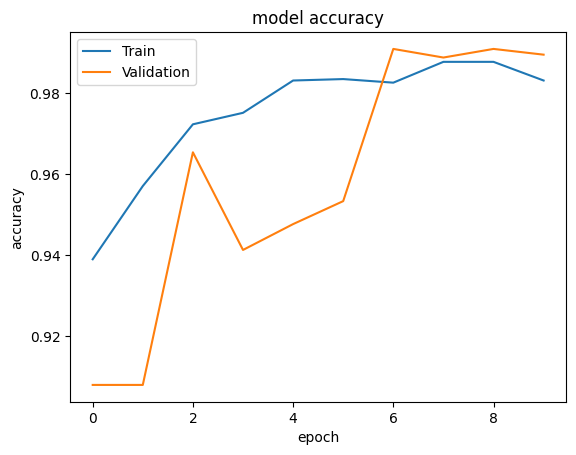

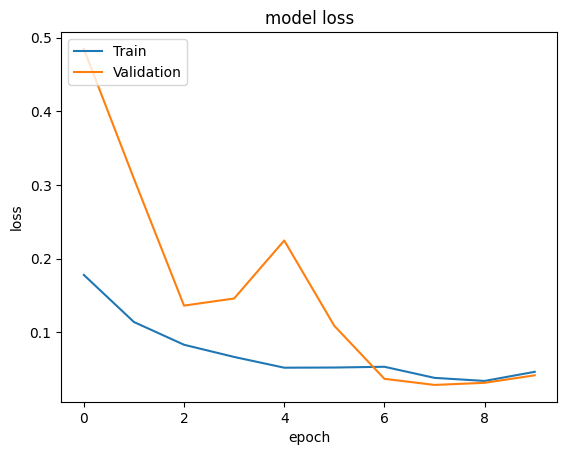

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [14]:
model.save('eye_check.h5')

/home/pooh555/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
